In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [3]:
from src.lib.fact_dataset_generator import FactDatasetGenerator
import numpy as np
import sys
import pandas as pd
import torch
import json

# Embeddings Experiment

### Loading training data embeddings

In [4]:
loaded_monofact_embeddings = []
loaded_normal_fact_embeddings = []


with open("../src/experiment/monofact_embeddings.json","r") as f:
    for line in f:
        loaded_monofact_embeddings.append(json.loads(line))
# with open("../src/experiment/hallucination_embeddings.json","r") as f:
#     for line in f:
#         loaded_hallucination_embeddings.append(json.loads(line))
with open("../src/experiment/normal_fact_embeddings.json","r") as f:
    for line in f:
        loaded_normal_fact_embeddings.append(json.loads(line))


In [5]:
monofact_embeddings = []
# hallucination_embeddings = []
normal_fact_embeddings = []
all_embeddings = []
embedding_of = []

for loaded_normal_fact, loaded_normal_fact_embedding in loaded_normal_fact_embeddings:
    normal_fact_embeddings.append((loaded_normal_fact, torch.tensor(loaded_normal_fact_embedding)))
    all_embeddings.append(torch.tensor(loaded_normal_fact_embedding))
    embedding_of.append('Popular fact')
for loaded_monofact, loaded_monofact_embedding in loaded_monofact_embeddings:
    monofact_embeddings.append((loaded_monofact, torch.tensor(loaded_monofact_embedding)))
    all_embeddings.append(torch.tensor(loaded_monofact_embedding))
    embedding_of.append('Monofact')
# for loaded_hallucination, loaded_hallucination_embedding in loaded_hallucination_embeddings:
#     hallucination_embeddings.append((loaded_hallucination, torch.tensor(loaded_hallucination_embedding)))
#     all_embeddings.append(torch.tensor(loaded_hallucination_embedding))
#     embedding_of.append('Hallucination')

In [6]:
all_embeddings = torch.cat([a.unsqueeze(0) for a in all_embeddings])

In [7]:
monofact_embeddings[0][1].shape

torch.Size([1536])

In [8]:
torch.cuda.empty_cache()

In [9]:
all_embeddings.shape

torch.Size([800, 1536])

In [10]:
all_embeddings_numpy = all_embeddings.detach().numpy()

In [11]:
all_embeddings_numpy

array([[ 0.5362337 , -0.03913231,  4.460196  , ...,  1.669704  ,
        -1.2950296 ,  0.02972578],
       [ 0.5362337 , -0.03913231,  4.460196  , ...,  0.03552325,
         3.2620003 ,  0.0574283 ],
       [ 0.5362337 , -0.03913231,  4.460196  , ...,  0.15969001,
        -1.3031412 ,  1.4547727 ],
       ...,
       [ 0.5362337 , -0.03913231,  4.460196  , ...,  1.0443217 ,
        -1.7883364 ,  0.27224025],
       [ 0.5362337 , -0.03913231,  4.460196  , ..., -0.25991872,
        -0.74759036, -0.49933898],
       [ 0.5362337 , -0.03913231,  4.460196  , ...,  0.33873427,
        -1.3436941 , -1.7039269 ]], dtype=float32)

In [12]:
import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(all_embeddings_numpy)
X_embedded.shape

(800, 2)

In [13]:
import matplotlib.pyplot as plt

In [14]:
colors = {
    'Hallucination': 'red',
    'Popular fact': 'lightblue',
    'Monofact': 'purple'
}

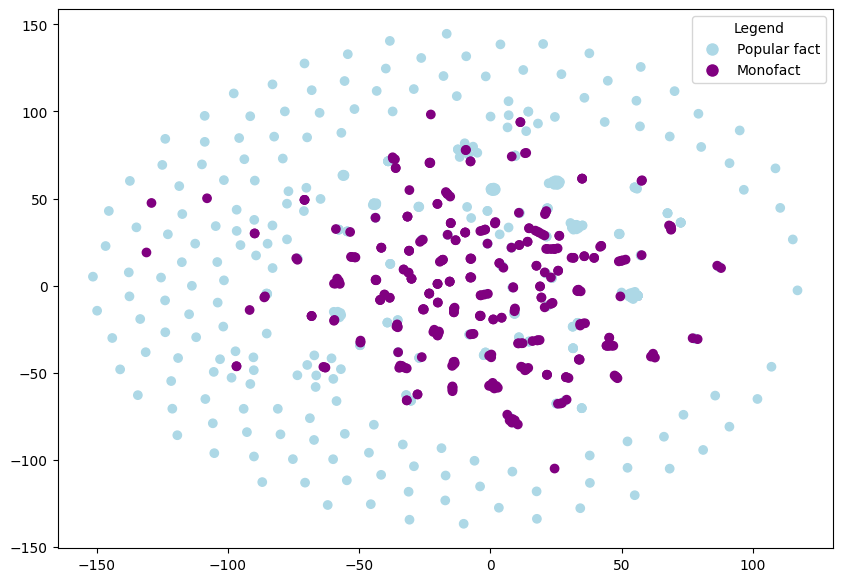

In [15]:
unique_labels = set(embedding_of)
label_color_map = {label: colors[label] for label in unique_labels}

# Create scatter plot
plt.figure(figsize=(10, 7))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=[colors[c] for c in embedding_of])

# Create a list of handles (proxy artists) for the legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for label, color in label_color_map.items()]
labels = list(label_color_map.keys())

# Add legend to the plot
plt.legend(handles, labels, title="Legend")

# Show the plot
# plt.savefig('figure.png', dpi=500)
plt.show()

## Load generated embeddings

In [30]:
generated_hallucinations_embeddings = []
with open("../src/experiment/hallucination_embeddings.json","r") as f:
    for line in f:
        generated_hallucinations_embeddings.append(json.loads(line))

generated_facts_embeddings = []
with open("../src/experiment/generated_fact_embeddings.json","r") as f:
    for line in f:
        generation = json.loads(line)
        is_hallucination = False

        # Filter out hallucinations
        for (hallucination, _) in generated_hallucinations_embeddings:
            if str(generation[0]) == str(hallucination):
                is_hallucination = True
                print(str(generation[0]))
                break

        if is_hallucination is False:
            generated_facts_embeddings.append(generation)

[0, 197, 14]


In [33]:
len(generated_facts_embeddings)

999

In [34]:
len(generated_hallucinations_embeddings)

34

In [35]:
from numpy import dot
import numpy as np
from numpy.linalg import norm

def dist(tensor_a, tensor_b):
    a = tensor_a.detach().numpy()
    b = tensor_b.detach().numpy()
    # return dot(a, b)/(norm(a)*norm(b))
    return np.linalg.norm(a-b)

In [46]:
def closest_different_point(embedding, top_k = 3):
    smallest_dist = 1E9
    result = None

    distances = []
    
    for loaded_monofact, loaded_monofact_embedding in loaded_monofact_embeddings:
        mf_embedding = torch.tensor(loaded_monofact_embedding)

        d = dist(embedding, mf_embedding)
        distances.append({'dist': d, 'type': 'Monofact'})
    # for loaded_hallucination, loaded_hallucination_embedding in loaded_hallucination_embeddings:
    #     hf_embedding = torch.tensor(loaded_hallucination_embedding)

    #     d = dist(embedding, hf_embedding)
    #     distances.append({'dist': d, 'type': 'Hallucination'})

    for loaded_normal_fact, loaded_normal_fact_embedding in loaded_normal_fact_embeddings:
        nf_embedding = torch.tensor(loaded_normal_fact_embedding)

        d = dist(embedding, nf_embedding)
        distances.append({'dist': d, 'type': 'Popular Fact'})

    return pd.DataFrame(distances).sort_values(by='dist').reset_index(drop=True)['type'].head(top_k).value_counts()

In [47]:
from tqdm import tqdm

In [49]:
result = []

for embedding in tqdm(generated_facts_embeddings):
    embedding = torch.Tensor(embedding[1])
    closest = dict(closest_different_point(embedding, top_k=3))

    closest_point = {'Monofact': 0, 'Hallucination': 0, 'Popular fact': 0}
    closest_point.update(**closest)

    closest_point['Point'] = 'Generated True Fact'

    print('Generated True Fact', closest)

    result.append(closest_point)

  0%|▎                                                                                                                                  | 2/999 [00:00<02:40,  6.21it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Monofact': 3}


  0%|▌                                                                                                                                  | 4/999 [00:00<02:37,  6.32it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Monofact': 3}


  1%|▊                                                                                                                                  | 6/999 [00:00<02:35,  6.40it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


  1%|█                                                                                                                                  | 8/999 [00:01<02:35,  6.37it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


  1%|█▎                                                                                                                                | 10/999 [00:01<02:35,  6.36it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


  1%|█▌                                                                                                                                | 12/999 [00:01<02:33,  6.42it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


  1%|█▊                                                                                                                                | 14/999 [00:02<02:32,  6.45it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


  2%|██                                                                                                                                | 16/999 [00:02<02:32,  6.43it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


  2%|██▏                                                                                                                               | 17/999 [00:02<02:37,  6.22it/s]

Generated True Fact {'Popular Fact': 3}


  2%|██▎                                                                                                                               | 18/999 [00:02<02:53,  5.65it/s]

Generated True Fact {'Monofact': 3}


  2%|██▌                                                                                                                               | 20/999 [00:03<03:03,  5.33it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


  2%|██▊                                                                                                                               | 22/999 [00:03<02:51,  5.68it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


  2%|███                                                                                                                               | 24/999 [00:03<02:42,  5.98it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


  3%|███▍                                                                                                                              | 26/999 [00:04<02:52,  5.65it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


  3%|███▋                                                                                                                              | 28/999 [00:04<02:51,  5.67it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Popular Fact': 3}


  3%|███▉                                                                                                                              | 30/999 [00:05<02:43,  5.94it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


  3%|████▏                                                                                                                             | 32/999 [00:05<02:42,  5.94it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


  3%|████▍                                                                                                                             | 34/999 [00:05<02:41,  5.96it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


  4%|████▋                                                                                                                             | 36/999 [00:06<02:37,  6.13it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


  4%|████▉                                                                                                                             | 38/999 [00:06<02:36,  6.14it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


  4%|█████▏                                                                                                                            | 40/999 [00:06<02:35,  6.16it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


  4%|█████▍                                                                                                                            | 42/999 [00:06<02:37,  6.08it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


  4%|█████▌                                                                                                                            | 43/999 [00:07<02:36,  6.12it/s]

Generated True Fact {'Monofact': 3}


  4%|█████▋                                                                                                                            | 44/999 [00:07<03:00,  5.29it/s]

Generated True Fact {'Popular Fact': 3}


  5%|█████▊                                                                                                                            | 45/999 [00:07<03:04,  5.18it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


  5%|█████▉                                                                                                                            | 46/999 [00:07<03:20,  4.74it/s]

Generated True Fact {'Monofact': 3}


  5%|██████▏                                                                                                                           | 48/999 [00:08<03:16,  4.85it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


  5%|██████▌                                                                                                                           | 50/999 [00:08<02:56,  5.37it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


  5%|██████▊                                                                                                                           | 52/999 [00:08<02:40,  5.89it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


  5%|███████                                                                                                                           | 54/999 [00:09<02:32,  6.18it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


  6%|███████▎                                                                                                                          | 56/999 [00:09<02:30,  6.26it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


  6%|███████▌                                                                                                                          | 58/999 [00:09<02:28,  6.33it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Popular Fact': 3}


  6%|███████▊                                                                                                                          | 60/999 [00:10<02:31,  6.19it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


  6%|████████                                                                                                                          | 62/999 [00:10<02:30,  6.24it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Popular Fact': 3}


  6%|████████▎                                                                                                                         | 64/999 [00:10<02:28,  6.32it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


  7%|████████▌                                                                                                                         | 66/999 [00:11<03:04,  5.05it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


  7%|████████▊                                                                                                                         | 68/999 [00:11<02:47,  5.55it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Popular Fact': 3}


  7%|████████▉                                                                                                                         | 69/999 [00:11<03:05,  5.02it/s]

Generated True Fact {'Monofact': 3}


  7%|█████████▏                                                                                                                        | 71/999 [00:12<02:55,  5.29it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


  7%|█████████▍                                                                                                                        | 73/999 [00:12<02:38,  5.83it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


  8%|█████████▊                                                                                                                        | 75/999 [00:12<02:34,  5.97it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


  8%|██████████                                                                                                                        | 77/999 [00:13<02:28,  6.22it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


  8%|██████████▎                                                                                                                       | 79/999 [00:13<02:24,  6.38it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


  8%|██████████▌                                                                                                                       | 81/999 [00:13<02:23,  6.41it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


  8%|██████████▊                                                                                                                       | 83/999 [00:14<02:42,  5.64it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


  9%|███████████                                                                                                                       | 85/999 [00:14<02:33,  5.96it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


  9%|███████████▎                                                                                                                      | 87/999 [00:14<02:32,  5.98it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


  9%|███████████▌                                                                                                                      | 89/999 [00:15<02:34,  5.88it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Monofact': 3}


  9%|███████████▊                                                                                                                      | 91/999 [00:15<02:29,  6.09it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


  9%|████████████                                                                                                                      | 93/999 [00:15<02:27,  6.14it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Popular Fact': 3}


 10%|████████████▎                                                                                                                     | 95/999 [00:16<02:26,  6.18it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 10%|████████████▌                                                                                                                     | 97/999 [00:16<02:23,  6.27it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 10%|████████████▉                                                                                                                     | 99/999 [00:16<02:25,  6.20it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 10%|█████████████                                                                                                                    | 101/999 [00:17<02:27,  6.11it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 10%|█████████████▎                                                                                                                   | 103/999 [00:17<02:24,  6.19it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Monofact': 3}


 11%|█████████████▌                                                                                                                   | 105/999 [00:17<02:28,  6.00it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 11%|█████████████▊                                                                                                                   | 107/999 [00:18<02:24,  6.16it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 11%|██████████████                                                                                                                   | 109/999 [00:18<02:29,  5.94it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


 11%|██████████████▎                                                                                                                  | 111/999 [00:18<02:29,  5.92it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 11%|██████████████▌                                                                                                                  | 113/999 [00:19<02:22,  6.21it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Popular Fact': 3}


 12%|██████████████▊                                                                                                                  | 115/999 [00:19<02:18,  6.37it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 12%|███████████████                                                                                                                  | 117/999 [00:19<02:16,  6.46it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


 12%|███████████████▎                                                                                                                 | 119/999 [00:20<02:24,  6.10it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 12%|███████████████▌                                                                                                                 | 121/999 [00:20<02:18,  6.36it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 12%|███████████████▉                                                                                                                 | 123/999 [00:20<02:16,  6.43it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 13%|████████████████▏                                                                                                                | 125/999 [00:21<02:14,  6.49it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 13%|████████████████▍                                                                                                                | 127/999 [00:21<02:13,  6.54it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


 13%|████████████████▋                                                                                                                | 129/999 [00:21<02:12,  6.57it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


 13%|████████████████▉                                                                                                                | 131/999 [00:21<02:13,  6.49it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 13%|█████████████████▏                                                                                                               | 133/999 [00:22<02:17,  6.30it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 14%|█████████████████▍                                                                                                               | 135/999 [00:22<02:13,  6.47it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Monofact': 3}


 14%|█████████████████▋                                                                                                               | 137/999 [00:22<02:12,  6.51it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 14%|█████████████████▉                                                                                                               | 139/999 [00:23<02:11,  6.52it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 14%|██████████████████▏                                                                                                              | 141/999 [00:23<02:10,  6.58it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 14%|██████████████████▍                                                                                                              | 143/999 [00:23<02:13,  6.41it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


 15%|██████████████████▋                                                                                                              | 145/999 [00:24<02:24,  5.90it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 15%|██████████████████▉                                                                                                              | 147/999 [00:24<02:19,  6.11it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 15%|███████████████████▏                                                                                                             | 149/999 [00:24<02:16,  6.21it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 15%|███████████████████▍                                                                                                             | 151/999 [00:25<02:14,  6.28it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 15%|███████████████████▊                                                                                                             | 153/999 [00:25<02:12,  6.38it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


 16%|████████████████████                                                                                                             | 155/999 [00:25<02:11,  6.43it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 16%|████████████████████▎                                                                                                            | 157/999 [00:26<02:11,  6.38it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 16%|████████████████████▌                                                                                                            | 159/999 [00:26<02:11,  6.40it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 16%|████████████████████▊                                                                                                            | 161/999 [00:26<02:09,  6.48it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 16%|█████████████████████                                                                                                            | 163/999 [00:26<02:08,  6.52it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 17%|█████████████████████▎                                                                                                           | 165/999 [00:27<02:07,  6.53it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 17%|█████████████████████▌                                                                                                           | 167/999 [00:27<02:07,  6.51it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 17%|█████████████████████▊                                                                                                           | 169/999 [00:27<02:07,  6.53it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Popular Fact': 3}


 17%|██████████████████████                                                                                                           | 171/999 [00:28<02:09,  6.42it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Popular Fact': 3}


 17%|██████████████████████▎                                                                                                          | 173/999 [00:28<02:07,  6.49it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 18%|██████████████████████▌                                                                                                          | 175/999 [00:28<02:06,  6.51it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 18%|██████████████████████▊                                                                                                          | 177/999 [00:29<02:06,  6.52it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 18%|███████████████████████                                                                                                          | 179/999 [00:29<02:05,  6.53it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 18%|███████████████████████▏                                                                                                         | 180/999 [00:29<02:08,  6.39it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 18%|███████████████████████▌                                                                                                         | 182/999 [00:29<02:17,  5.95it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 18%|███████████████████████▊                                                                                                         | 184/999 [00:30<02:13,  6.12it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


 19%|████████████████████████                                                                                                         | 186/999 [00:30<02:11,  6.18it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 19%|████████████████████████▎                                                                                                        | 188/999 [00:30<02:07,  6.35it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 19%|████████████████████████▌                                                                                                        | 190/999 [00:31<02:17,  5.90it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 19%|████████████████████████▊                                                                                                        | 192/999 [00:31<02:17,  5.87it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 19%|█████████████████████████                                                                                                        | 194/999 [00:31<02:09,  6.19it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 20%|█████████████████████████▎                                                                                                       | 196/999 [00:32<02:06,  6.34it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 20%|█████████████████████████▌                                                                                                       | 198/999 [00:32<02:05,  6.38it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 20%|█████████████████████████▊                                                                                                       | 200/999 [00:32<02:03,  6.44it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Popular Fact': 3}


 20%|██████████████████████████                                                                                                       | 202/999 [00:33<02:02,  6.50it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 20%|██████████████████████████▎                                                                                                      | 204/999 [00:33<02:02,  6.47it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


 21%|██████████████████████████▌                                                                                                      | 206/999 [00:33<02:03,  6.41it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


 21%|██████████████████████████▊                                                                                                      | 208/999 [00:34<02:08,  6.15it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 21%|███████████████████████████                                                                                                      | 210/999 [00:34<02:05,  6.31it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Monofact': 3}


 21%|███████████████████████████▍                                                                                                     | 212/999 [00:34<02:02,  6.41it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 21%|███████████████████████████▋                                                                                                     | 214/999 [00:35<02:02,  6.41it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Monofact': 3}


 22%|███████████████████████████▉                                                                                                     | 216/999 [00:35<02:00,  6.50it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 22%|████████████████████████████▏                                                                                                    | 218/999 [00:35<02:00,  6.47it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


 22%|████████████████████████████▍                                                                                                    | 220/999 [00:35<01:59,  6.52it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 22%|████████████████████████████▋                                                                                                    | 222/999 [00:36<01:58,  6.55it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 22%|████████████████████████████▉                                                                                                    | 224/999 [00:36<01:58,  6.54it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


 23%|█████████████████████████████▏                                                                                                   | 226/999 [00:36<01:58,  6.51it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 23%|█████████████████████████████▍                                                                                                   | 228/999 [00:37<01:58,  6.53it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 23%|█████████████████████████████▋                                                                                                   | 230/999 [00:37<01:58,  6.47it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 23%|█████████████████████████████▉                                                                                                   | 232/999 [00:37<01:57,  6.53it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Popular Fact': 3}


 23%|██████████████████████████████▏                                                                                                  | 234/999 [00:38<02:01,  6.27it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 24%|██████████████████████████████▍                                                                                                  | 236/999 [00:38<01:58,  6.44it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


 24%|██████████████████████████████▋                                                                                                  | 238/999 [00:38<02:00,  6.34it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 24%|██████████████████████████████▉                                                                                                  | 240/999 [00:39<01:57,  6.47it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Popular Fact': 3}


 24%|███████████████████████████████▏                                                                                                 | 242/999 [00:39<01:56,  6.52it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


 24%|███████████████████████████████▌                                                                                                 | 244/999 [00:39<01:55,  6.56it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 25%|███████████████████████████████▊                                                                                                 | 246/999 [00:39<01:54,  6.59it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 25%|████████████████████████████████                                                                                                 | 248/999 [00:40<01:55,  6.52it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 25%|████████████████████████████████▎                                                                                                | 250/999 [00:40<01:54,  6.53it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 25%|████████████████████████████████▌                                                                                                | 252/999 [00:40<01:53,  6.57it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 25%|████████████████████████████████▊                                                                                                | 254/999 [00:41<01:53,  6.55it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Monofact': 3}


 26%|█████████████████████████████████                                                                                                | 256/999 [00:41<01:53,  6.57it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 26%|█████████████████████████████████▎                                                                                               | 258/999 [00:41<01:55,  6.41it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 26%|█████████████████████████████████▌                                                                                               | 260/999 [00:42<01:54,  6.47it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 26%|█████████████████████████████████▊                                                                                               | 262/999 [00:42<01:56,  6.34it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Monofact': 3}


 26%|██████████████████████████████████                                                                                               | 264/999 [00:42<01:53,  6.47it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 27%|██████████████████████████████████▎                                                                                              | 266/999 [00:43<01:55,  6.34it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 27%|██████████████████████████████████▌                                                                                              | 268/999 [00:43<01:55,  6.33it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Monofact': 3}


 27%|██████████████████████████████████▊                                                                                              | 270/999 [00:43<01:55,  6.33it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 27%|███████████████████████████████████                                                                                              | 272/999 [00:44<01:56,  6.26it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 27%|███████████████████████████████████▍                                                                                             | 274/999 [00:44<01:55,  6.30it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 28%|███████████████████████████████████▋                                                                                             | 276/999 [00:44<01:54,  6.32it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 28%|███████████████████████████████████▉                                                                                             | 278/999 [00:44<01:54,  6.32it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 28%|████████████████████████████████████▏                                                                                            | 280/999 [00:45<01:56,  6.19it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


 28%|████████████████████████████████████▍                                                                                            | 282/999 [00:45<01:54,  6.27it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 28%|████████████████████████████████████▋                                                                                            | 284/999 [00:45<01:53,  6.30it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


 29%|████████████████████████████████████▉                                                                                            | 286/999 [00:46<01:56,  6.13it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Monofact': 3}


 29%|█████████████████████████████████████                                                                                            | 287/999 [00:46<01:58,  6.02it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 29%|█████████████████████████████████████▎                                                                                           | 289/999 [00:46<02:01,  5.83it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 29%|█████████████████████████████████████▌                                                                                           | 291/999 [00:47<01:55,  6.11it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


 29%|█████████████████████████████████████▊                                                                                           | 293/999 [00:47<01:51,  6.31it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 30%|██████████████████████████████████████                                                                                           | 295/999 [00:47<01:49,  6.40it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 30%|██████████████████████████████████████▎                                                                                          | 297/999 [00:48<01:49,  6.44it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 30%|██████████████████████████████████████▌                                                                                          | 299/999 [00:48<01:48,  6.47it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


 30%|██████████████████████████████████████▊                                                                                          | 301/999 [00:48<01:52,  6.23it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 30%|███████████████████████████████████████▏                                                                                         | 303/999 [00:48<01:49,  6.35it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 31%|███████████████████████████████████████▍                                                                                         | 305/999 [00:49<01:49,  6.36it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


 31%|███████████████████████████████████████▋                                                                                         | 307/999 [00:49<01:49,  6.32it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 31%|███████████████████████████████████████▉                                                                                         | 309/999 [00:49<01:49,  6.29it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 31%|████████████████████████████████████████▏                                                                                        | 311/999 [00:50<01:49,  6.30it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


 31%|████████████████████████████████████████▍                                                                                        | 313/999 [00:50<01:49,  6.25it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 32%|████████████████████████████████████████▋                                                                                        | 315/999 [00:50<01:49,  6.22it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 32%|████████████████████████████████████████▉                                                                                        | 317/999 [00:51<01:50,  6.15it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 32%|█████████████████████████████████████████▏                                                                                       | 319/999 [00:51<01:47,  6.32it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Popular Fact': 3}


 32%|█████████████████████████████████████████▍                                                                                       | 321/999 [00:51<01:45,  6.40it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 32%|█████████████████████████████████████████▋                                                                                       | 323/999 [00:52<01:45,  6.43it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 33%|█████████████████████████████████████████▉                                                                                       | 325/999 [00:52<01:45,  6.40it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 33%|██████████████████████████████████████████▏                                                                                      | 327/999 [00:52<01:44,  6.42it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


 33%|██████████████████████████████████████████▍                                                                                      | 329/999 [00:53<01:44,  6.40it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


 33%|██████████████████████████████████████████▋                                                                                      | 331/999 [00:53<01:43,  6.44it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 33%|███████████████████████████████████████████                                                                                      | 333/999 [00:53<01:43,  6.40it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 34%|███████████████████████████████████████████▎                                                                                     | 335/999 [00:54<01:44,  6.37it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 34%|███████████████████████████████████████████▌                                                                                     | 337/999 [00:54<01:43,  6.41it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 34%|███████████████████████████████████████████▋                                                                                     | 338/999 [00:54<01:43,  6.41it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 34%|███████████████████████████████████████████▉                                                                                     | 340/999 [00:54<01:51,  5.94it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 34%|████████████████████████████████████████████▏                                                                                    | 342/999 [00:55<01:45,  6.21it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Popular Fact': 3}


 34%|████████████████████████████████████████████▍                                                                                    | 344/999 [00:55<01:49,  5.98it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Popular Fact': 3}


 35%|████████████████████████████████████████████▋                                                                                    | 346/999 [00:55<01:47,  6.05it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 35%|████████████████████████████████████████████▉                                                                                    | 348/999 [00:56<01:43,  6.27it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


 35%|█████████████████████████████████████████████▏                                                                                   | 350/999 [00:56<01:43,  6.29it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 35%|█████████████████████████████████████████████▍                                                                                   | 352/999 [00:56<01:40,  6.42it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 35%|█████████████████████████████████████████████▋                                                                                   | 354/999 [00:57<01:41,  6.37it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 36%|█████████████████████████████████████████████▉                                                                                   | 356/999 [00:57<01:41,  6.33it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 36%|██████████████████████████████████████████████▏                                                                                  | 358/999 [00:57<01:40,  6.36it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 36%|██████████████████████████████████████████████▍                                                                                  | 360/999 [00:58<01:39,  6.42it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Monofact': 3}


 36%|██████████████████████████████████████████████▋                                                                                  | 362/999 [00:58<01:41,  6.26it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 36%|███████████████████████████████████████████████                                                                                  | 364/999 [00:58<01:43,  6.11it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


 37%|███████████████████████████████████████████████▎                                                                                 | 366/999 [00:59<01:54,  5.52it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Monofact': 3}


 37%|███████████████████████████████████████████████▌                                                                                 | 368/999 [00:59<01:47,  5.87it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 37%|███████████████████████████████████████████████▊                                                                                 | 370/999 [00:59<01:43,  6.06it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


 37%|████████████████████████████████████████████████                                                                                 | 372/999 [01:00<01:44,  5.99it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 37%|████████████████████████████████████████████████▎                                                                                | 374/999 [01:00<01:40,  6.20it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 38%|████████████████████████████████████████████████▌                                                                                | 376/999 [01:00<01:39,  6.24it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


 38%|████████████████████████████████████████████████▊                                                                                | 378/999 [01:01<01:40,  6.17it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 38%|█████████████████████████████████████████████████                                                                                | 380/999 [01:01<01:38,  6.31it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


 38%|█████████████████████████████████████████████████▎                                                                               | 382/999 [01:01<01:50,  5.58it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


 38%|█████████████████████████████████████████████████▌                                                                               | 384/999 [01:02<01:57,  5.26it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 39%|█████████████████████████████████████████████████▊                                                                               | 386/999 [01:02<01:59,  5.12it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 39%|██████████████████████████████████████████████████                                                                               | 388/999 [01:02<01:51,  5.48it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 39%|██████████████████████████████████████████████████▎                                                                              | 390/999 [01:03<01:47,  5.64it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 39%|██████████████████████████████████████████████████▌                                                                              | 392/999 [01:03<01:44,  5.79it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 39%|██████████████████████████████████████████████████▉                                                                              | 394/999 [01:03<01:42,  5.91it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 40%|███████████████████████████████████████████████████▏                                                                             | 396/999 [01:04<01:38,  6.12it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 40%|███████████████████████████████████████████████████▍                                                                             | 398/999 [01:04<01:44,  5.74it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 40%|███████████████████████████████████████████████████▋                                                                             | 400/999 [01:04<01:42,  5.86it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 40%|███████████████████████████████████████████████████▉                                                                             | 402/999 [01:05<01:43,  5.76it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Popular Fact': 3}


 40%|████████████████████████████████████████████████████▏                                                                            | 404/999 [01:05<01:40,  5.92it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 41%|████████████████████████████████████████████████████▎                                                                            | 405/999 [01:05<01:43,  5.75it/s]

Generated True Fact {'Monofact': 3}


 41%|████████████████████████████████████████████████████▌                                                                            | 407/999 [01:06<01:45,  5.60it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 41%|████████████████████████████████████████████████████▊                                                                            | 409/999 [01:06<01:39,  5.95it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 41%|█████████████████████████████████████████████████████                                                                            | 411/999 [01:06<01:54,  5.14it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Monofact': 3}


 41%|█████████████████████████████████████████████████████▎                                                                           | 413/999 [01:07<01:51,  5.25it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Popular Fact': 3}


 42%|█████████████████████████████████████████████████████▌                                                                           | 415/999 [01:07<01:42,  5.71it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 42%|█████████████████████████████████████████████████████▊                                                                           | 417/999 [01:08<01:38,  5.90it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 42%|██████████████████████████████████████████████████████                                                                           | 419/999 [01:08<01:34,  6.14it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Popular Fact': 3}


 42%|██████████████████████████████████████████████████████▎                                                                          | 421/999 [01:08<01:31,  6.32it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 42%|██████████████████████████████████████████████████████▍                                                                          | 422/999 [01:08<01:31,  6.33it/s]

Generated True Fact {'Monofact': 3}


 42%|██████████████████████████████████████████████████████▊                                                                          | 424/999 [01:09<01:44,  5.49it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 43%|███████████████████████████████████████████████████████                                                                          | 426/999 [01:09<01:41,  5.62it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


 43%|███████████████████████████████████████████████████████▎                                                                         | 428/999 [01:09<01:36,  5.94it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Monofact': 3}


 43%|███████████████████████████████████████████████████████▌                                                                         | 430/999 [01:10<01:31,  6.22it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Monofact': 3}


 43%|███████████████████████████████████████████████████████▊                                                                         | 432/999 [01:10<01:28,  6.42it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Popular Fact': 3}


 43%|████████████████████████████████████████████████████████                                                                         | 434/999 [01:10<01:26,  6.51it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 44%|████████████████████████████████████████████████████████▎                                                                        | 436/999 [01:11<01:25,  6.57it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 44%|████████████████████████████████████████████████████████▌                                                                        | 438/999 [01:11<01:28,  6.35it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 44%|████████████████████████████████████████████████████████▊                                                                        | 440/999 [01:11<01:27,  6.40it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


 44%|█████████████████████████████████████████████████████████                                                                        | 442/999 [01:12<01:29,  6.23it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Monofact': 3}


 44%|█████████████████████████████████████████████████████████▎                                                                       | 444/999 [01:12<01:27,  6.38it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


 45%|█████████████████████████████████████████████████████████▌                                                                       | 446/999 [01:12<01:28,  6.26it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 45%|█████████████████████████████████████████████████████████▊                                                                       | 448/999 [01:13<01:26,  6.35it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 45%|██████████████████████████████████████████████████████████                                                                       | 450/999 [01:13<01:30,  6.10it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 45%|██████████████████████████████████████████████████████████▎                                                                      | 452/999 [01:13<01:29,  6.11it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


 45%|██████████████████████████████████████████████████████████▌                                                                      | 454/999 [01:14<01:30,  6.01it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 46%|██████████████████████████████████████████████████████████▉                                                                      | 456/999 [01:14<01:32,  5.89it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 46%|███████████████████████████████████████████████████████████▏                                                                     | 458/999 [01:14<01:30,  5.96it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 46%|███████████████████████████████████████████████████████████▍                                                                     | 460/999 [01:15<01:28,  6.12it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


 46%|███████████████████████████████████████████████████████████▋                                                                     | 462/999 [01:15<01:29,  6.00it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 46%|███████████████████████████████████████████████████████████▉                                                                     | 464/999 [01:15<01:25,  6.26it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


 47%|████████████████████████████████████████████████████████████▏                                                                    | 466/999 [01:15<01:22,  6.43it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 47%|████████████████████████████████████████████████████████████▍                                                                    | 468/999 [01:16<01:21,  6.49it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Popular Fact': 3}


 47%|████████████████████████████████████████████████████████████▋                                                                    | 470/999 [01:16<01:20,  6.53it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 47%|████████████████████████████████████████████████████████████▉                                                                    | 472/999 [01:16<01:32,  5.67it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 47%|█████████████████████████████████████████████████████████████▏                                                                   | 474/999 [01:17<01:28,  5.91it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 48%|█████████████████████████████████████████████████████████████▍                                                                   | 476/999 [01:17<01:24,  6.19it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 48%|█████████████████████████████████████████████████████████████▋                                                                   | 478/999 [01:17<01:27,  5.93it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Popular Fact': 3}


 48%|█████████████████████████████████████████████████████████████▉                                                                   | 480/999 [01:18<01:24,  6.17it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Popular Fact': 3}


 48%|██████████████████████████████████████████████████████████████▏                                                                  | 482/999 [01:18<01:21,  6.31it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


 48%|██████████████████████████████████████████████████████████████▍                                                                  | 484/999 [01:18<01:22,  6.28it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 49%|██████████████████████████████████████████████████████████████▊                                                                  | 486/999 [01:19<01:22,  6.22it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Monofact': 3}


 49%|███████████████████████████████████████████████████████████████                                                                  | 488/999 [01:19<01:24,  6.08it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 49%|███████████████████████████████████████████████████████████████▎                                                                 | 490/999 [01:19<01:25,  5.97it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 49%|███████████████████████████████████████████████████████████████▌                                                                 | 492/999 [01:20<01:23,  6.09it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 49%|███████████████████████████████████████████████████████████████▊                                                                 | 494/999 [01:20<01:22,  6.15it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 50%|████████████████████████████████████████████████████████████████                                                                 | 496/999 [01:20<01:20,  6.24it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


 50%|████████████████████████████████████████████████████████████████▎                                                                | 498/999 [01:21<01:23,  6.00it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 50%|████████████████████████████████████████████████████████████████▌                                                                | 500/999 [01:21<01:27,  5.71it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 50%|████████████████████████████████████████████████████████████████▊                                                                | 502/999 [01:21<01:26,  5.75it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 50%|████████████████████████████████████████████████████████████████▉                                                                | 503/999 [01:22<01:31,  5.42it/s]

Generated True Fact {'Popular Fact': 3}


 51%|█████████████████████████████████████████████████████████████████▏                                                               | 505/999 [01:22<01:28,  5.56it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 51%|█████████████████████████████████████████████████████████████████▍                                                               | 507/999 [01:22<01:23,  5.86it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 51%|█████████████████████████████████████████████████████████████████▋                                                               | 509/999 [01:23<01:22,  5.97it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Monofact': 3}


 51%|█████████████████████████████████████████████████████████████████▉                                                               | 511/999 [01:23<01:19,  6.16it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 51%|██████████████████████████████████████████████████████████████████▏                                                              | 513/999 [01:23<01:17,  6.30it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 52%|██████████████████████████████████████████████████████████████████▌                                                              | 515/999 [01:24<01:17,  6.28it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 52%|██████████████████████████████████████████████████████████████████▊                                                              | 517/999 [01:24<01:16,  6.27it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Popular Fact': 3}


 52%|███████████████████████████████████████████████████████████████████                                                              | 519/999 [01:24<01:16,  6.26it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 52%|███████████████████████████████████████████████████████████████████▎                                                             | 521/999 [01:25<01:21,  5.86it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


 52%|███████████████████████████████████████████████████████████████████▌                                                             | 523/999 [01:25<01:17,  6.13it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 53%|███████████████████████████████████████████████████████████████████▊                                                             | 525/999 [01:25<01:15,  6.24it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


 53%|████████████████████████████████████████████████████████████████████                                                             | 527/999 [01:26<01:18,  6.00it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 53%|████████████████████████████████████████████████████████████████████▎                                                            | 529/999 [01:26<01:21,  5.76it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 53%|████████████████████████████████████████████████████████████████████▌                                                            | 531/999 [01:26<01:16,  6.10it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 53%|████████████████████████████████████████████████████████████████████▊                                                            | 533/999 [01:27<01:16,  6.11it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


 54%|█████████████████████████████████████████████████████████████████████                                                            | 535/999 [01:27<01:16,  6.10it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Popular Fact': 3}


 54%|█████████████████████████████████████████████████████████████████████▎                                                           | 537/999 [01:27<01:19,  5.85it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 54%|█████████████████████████████████████████████████████████████████████▌                                                           | 539/999 [01:28<01:16,  6.04it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 54%|█████████████████████████████████████████████████████████████████████▊                                                           | 541/999 [01:28<01:16,  6.00it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


 54%|██████████████████████████████████████████████████████████████████████                                                           | 543/999 [01:28<01:16,  5.99it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


 55%|██████████████████████████████████████████████████████████████████████▍                                                          | 545/999 [01:29<01:20,  5.66it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Monofact': 3}


 55%|██████████████████████████████████████████████████████████████████████▋                                                          | 547/999 [01:29<01:17,  5.82it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 55%|██████████████████████████████████████████████████████████████████████▉                                                          | 549/999 [01:29<01:15,  5.92it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 55%|███████████████████████████████████████████████████████████████████████▏                                                         | 551/999 [01:30<01:15,  5.94it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 55%|███████████████████████████████████████████████████████████████████████▎                                                         | 552/999 [01:30<01:20,  5.58it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 55%|███████████████████████████████████████████████████████████████████████▌                                                         | 554/999 [01:30<01:23,  5.35it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Popular Fact': 3}


 56%|███████████████████████████████████████████████████████████████████████▋                                                         | 555/999 [01:30<01:21,  5.45it/s]

Generated True Fact {'Popular Fact': 3}


 56%|███████████████████████████████████████████████████████████████████████▉                                                         | 557/999 [01:31<01:29,  4.92it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


 56%|████████████████████████████████████████████████████████████████████████▏                                                        | 559/999 [01:31<01:21,  5.41it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 56%|████████████████████████████████████████████████████████████████████████▍                                                        | 561/999 [01:32<01:15,  5.83it/s]

Generated True Fact {'Monofact': 2, 'Popular Fact': 1}
Generated True Fact {'Popular Fact': 3}


 56%|████████████████████████████████████████████████████████████████████████▋                                                        | 563/999 [01:32<01:15,  5.77it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


 57%|████████████████████████████████████████████████████████████████████████▉                                                        | 565/999 [01:32<01:12,  5.97it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 57%|█████████████████████████████████████████████████████████████████████████▏                                                       | 567/999 [01:33<01:10,  6.14it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 569/999 [01:33<01:07,  6.36it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 571/999 [01:33<01:07,  6.35it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 573/999 [01:33<01:06,  6.41it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 57%|██████████████████████████████████████████████████████████████████████████                                                       | 574/999 [01:34<01:09,  6.10it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


KeyboardInterrupt: 

In [51]:
# For every point how many times Monofact was the closest, Hallucination was the closest and Popular Fact was the closest
pd.DataFrame(result).groupby(by='Point').sum()

,Monofact,Hallucination,Popular fact,Popular Fact
Point,,,,
Generated True Fact,1017,0,0,705.0
